## Access SOOP FishSOOP NRT data in Parquet

A jupyter notebook to show how to access and plot SOOP FishSOOP NRT data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/bdb84466-dc53-49ad-a60f-83d9fa0baed5).

📌 The point of truth for this notebook is [on GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/vessel_fishsoop_realtime_qc.ipynb).

In [1]:
dataset_name = "vessel_fishsoop_realtime_qc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 58ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 897 ms, sys: 160 ms, total: 1.06 s
Wall time: 11.4 s


In [5]:
aodn_dataset.dataset.partitioning.schema

timestamp: int32
polygon: string

## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


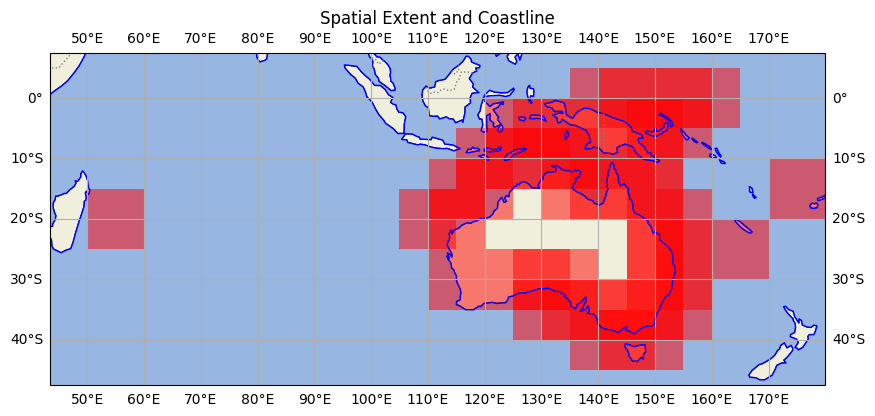

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [7]:
aodn_dataset.get_temporal_extent()

(Timestamp('2021-11-20 22:24:37.999999744'), Timestamp('2025-04-27 21:04:44'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:24:33,137 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/vessel_fishsoop_realtime_qc.parquet
2025-06-05 13:24:33,250 - aodn.GetAodn - WARNING - Old 'dataset_medata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'TRAJECTORY_ID': {'type': 'double',
  'long_name': 'trajectory identifier',
  'cf_role': 'trajectory_id'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 21915.0,
  'valid_max': 90000.0,
  'comment': 'The valid_min is set to January 1st, 2010, dates before this time are flagged by the quality control impossible date test'},
 'LATITUDE': {'type': 'float',
  'ancillary_variables': 'LATITUDE_quality_control',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'axis': 'Y',
  'reference_datum': 'WGS84 geographic coordinate system'},
 'LATITUDE_quality_control': {'type': 'int32',
  'long_name': 'quality flag for latitude',
  'standard_name': 'latitude status_flag',
  'quality_control_conventions': 'IMOS standard flags',
  'flag_values': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'flag_meanings': 'No_QC_performed Good_data Probably_good_data Bad_data_that

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2021-01-31 10:14:00', date_end='2023-09-01 07:50:00',lat_min=-40, lat_max=-32, lon_min=130, lon_max=150)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85601 entries, 0 to 85600
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TRAJECTORY_ID                85601 non-null  float64       
 1   TIME                         85601 non-null  datetime64[ns]
 2   LATITUDE                     85601 non-null  float32       
 3   LATITUDE_quality_control     85601 non-null  int32         
 4   LONGITUDE                    85601 non-null  float32       
 5   LONGITUDE_quality_control    85601 non-null  int32         
 6   DEPTH                        85601 non-null  float32       
 7   DEPTH_quality_control        85601 non-null  int32         
 8   TEMPERATURE                  85601 non-null  float32       
 9   TEMPERATURE_quality_control  85601 non-null  int32         
 10  PRES                         85601 non-null  float32       
 11  PRES_quality_control         85601 non-nu

In [ ]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

<Axes: xlabel='latitude', ylabel='depth'>

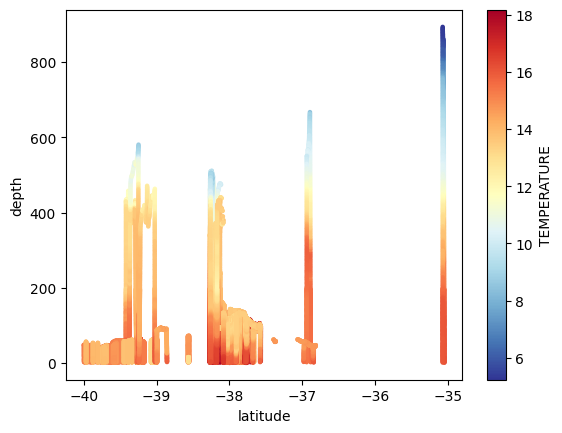

In [10]:
df[df['TEMPERATURE_quality_control'] == 1].sort_values('TIME').plot.scatter(x='LATITUDE', y='DEPTH', c='TEMPERATURE', 
                                                                     xlabel=metadata['LATITUDE']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None")


<Axes: xlabel='longitude', ylabel='depth'>

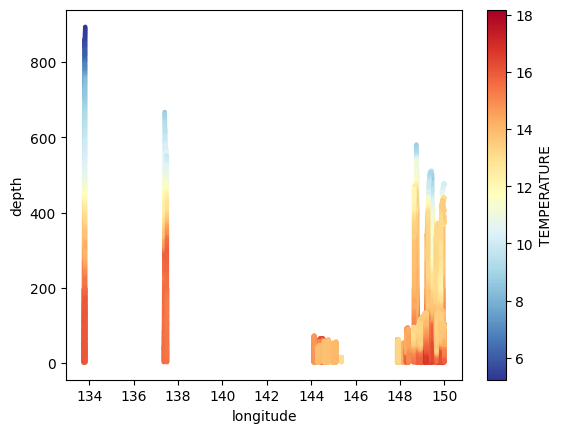

In [11]:
df[df['TEMPERATURE_quality_control'] == 1].sort_values('TIME').plot.scatter(x='LONGITUDE', y='DEPTH', c='TEMPERATURE', 
                                                                     xlabel=metadata['LONGITUDE']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None")

## Create a 3D plot of the Temperature

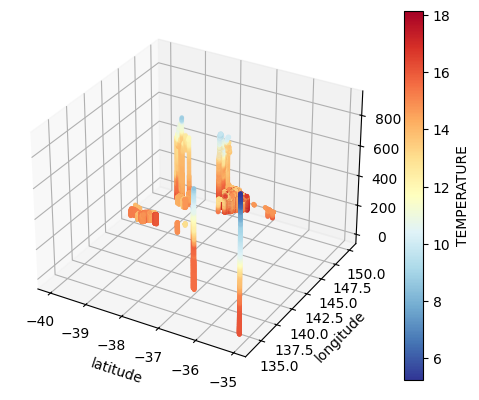

In [12]:
import matplotlib.pyplot as plt

filtered_df = df[df['TEMPERATURE_quality_control'] == 1].sort_values('TIME')

latitude = filtered_df['LATITUDE']
longitude = filtered_df['LONGITUDE']
depth = filtered_df['DEPTH']
temperature = filtered_df['TEMPERATURE']

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(latitude, longitude, depth, c=temperature, cmap='RdYlBu_r', marker='.')

# Add labels
ax.set_xlabel(metadata['LATITUDE']['standard_name'])
ax.set_ylabel(metadata['LONGITUDE']['standard_name'])
ax.set_zlabel(metadata['DEPTH']['standard_name'])

cbar = plt.colorbar(sc)
cbar.set_label('TEMPERATURE')

plt.show()